In [1]:
!pip install -q tensorflow_hub librosa resampy
!pip install tensorflow==2.13.1

import os
import time
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GRU, Bidirectional, Layer, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.9 MB/s eta 0:00:00:00:01
INFO: pip is looking at multiple versions of grpcio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 39.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 93.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 56.2 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 29.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0
  Attempting uninstall: numpy
    Found existing installation:

In [2]:
DATA_ROOT = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/'

# --- MODEL SAVING PATH ---
MODEL_SAVE_PATH = '/kaggle/working/yamnet_gtzan_model.h5'
EMBED_CACHE_X = '/kaggle/working/X_embeddings.npy'
EMBED_CACHE_Y = '/kaggle/working/y_labels.npy'
SEG_CACHE = '/kaggle/working/segment_counts.npy'  # optional: store number of segments per file

# YAMNet TF-Hub handle
YAMNET_HANDLE = '/kaggle/input/yamnet/tensorflow2/yamnet/1'

# Audio & segmentation config (tweak for balance compute vs. temporal resolution)
SR = 16000                 # target sampling rate for YAMNet
MAX_AUDIO_DURATION = 180   # seconds: supports up to 3 minutes
SEGMENT_SECONDS = 10       # seconds per segment for embedding extraction
HOP_SECONDS = 5            # hop (overlap) between segments
EMBEDDING_SIZE = 1024      # YAMNet embedding dim

# Training config
BATCH_SIZE = 32
EPOCHS = 50
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Model choice: keep original DNN or improved temporal model
USE_IMPROVED_MODEL = True  # set False to use simple mean-aggregated DNN

In [3]:
def list_audio_files(root_dir):
    root = Path(root_dir)
    if not root.exists():
        raise FileNotFoundError(f"DATA_ROOT not found: {root_dir}")
    files = []
    for genre_dir in sorted([d for d in root.iterdir() if d.is_dir()]):
        genre = genre_dir.name
        for f in genre_dir.glob('*'):
            if f.suffix.lower() in ['.wav', '.au', '.mp3', '.aif', '.aiff']:
                files.append((str(f), genre))
    return files

def load_audio_segments(path, sr=SR, max_duration=MAX_AUDIO_DURATION, segment_seconds=SEGMENT_SECONDS, hop_seconds=HOP_SECONDS):
    """
    Load audio (up to max_duration), resample to sr, return list of segments (np arrays),
    each segment length = segment_seconds * sr. Overlap controlled by hop_seconds.
    """
    # librosa.load supports `duration` for early stop
    waveform, _ = librosa.load(path, sr=sr, mono=True, duration=max_duration)
    seg_len = int(segment_seconds * sr)
    hop_len = int(hop_seconds * sr)
    if waveform.size == 0:
        return []
    segments = []
    if len(waveform) <= seg_len:
        # pad onto single segment
        if len(waveform) < seg_len:
            waveform = np.pad(waveform, (0, seg_len - len(waveform)))
        segments.append(waveform[:seg_len])
        return segments
    # sliding windows
    for start in range(0, max(1, len(waveform) - seg_len + 1), hop_len):
        seg = waveform[start:start + seg_len]
        if len(seg) < seg_len:
            seg = np.pad(seg, (0, seg_len - len(seg)))
        segments.append(seg)
    return segments

In [4]:
print("Loading YAMNet from TF-Hub...")
yamnet_model = hub.load(YAMNET_HANDLE)  # returns callable model: yamnet_model(waveform) -> (scores, embeddings, spec)
print("YAMNet loaded.")

# wrapper to get per-segment embedding
def compute_segment_embedding(waveform_segment):
    """
    waveform_segment: 1D numpy array with sr samples (float32)
    returns: 1D numpy array of length EMBEDDING_SIZE (mean across frames)
    """
    # convert to tensor
    waveform = tf.convert_to_tensor(waveform_segment, dtype=tf.float32)
    try:
        scores, embeddings, spec = yamnet_model(waveform)
    except Exception as e:
        # If single tensor call fails (expected shape), try expanding dims
        waveform2 = tf.expand_dims(waveform, axis=0)
        scores, embeddings, spec = yamnet_model(waveform2)
    # embeddings: shape (frames, embedding_size)
    emb = np.mean(embeddings.numpy(), axis=0)
    return emb

Loading YAMNet from TF-Hub...
YAMNet loaded.


In [5]:
audio_label_pairs = list_audio_files(DATA_ROOT)
print(f"Found {len(audio_label_pairs)} audio files (example):", audio_label_pairs[:3])

labels_sorted = sorted(list({lbl for _, lbl in audio_label_pairs}))
label_to_idx = {l:i for i,l in enumerate(labels_sorted)}
print("Labels:", labels_sorted)

# If cached embeddings exist, load them
if os.path.exists(EMBED_CACHE_X) and os.path.exists(EMBED_CACHE_Y) and os.path.exists(SEG_CACHE):
    print("Loading cached embeddings from:", EMBED_CACHE_X, EMBED_CACHE_Y)
    X = np.load(EMBED_CACHE_X)
    y = np.load(EMBED_CACHE_Y)
    segment_counts = np.load(SEG_CACHE)
    print("Loaded X shape:", X.shape, "y shape:", y.shape)
else:
    # Extract embeddings (per-file). If USE_IMPROVED_MODEL, we will store per-file segment embeddings
    X_list = []          # if USE_IMPROVED_MODEL==False: store aggregated 1D vector per file
    seg_counts = []      # number of segments per file (for optional debugging)
    y_list = []
    # If improved model: we will store list of arrays (num_segments x embed_dim) for each file
    # but to allow batching in training we pad/truncate sequences later. For cache we save mean-aggregations
    # and optionally save per-file segment counts.
    start_time = time.time()
    for i, (path, lbl) in enumerate(audio_label_pairs):
        try:
            segments = load_audio_segments(path)
            if len(segments) == 0:
                print(f"Skipping empty: {path}")
                continue
            seg_embs = []
            for seg in segments:
                emb = compute_segment_embedding(seg)
                seg_embs.append(emb)
            seg_embs = np.stack(seg_embs, axis=0)  # shape (num_segments, EMBEDDING_SIZE)
            # store aggregated embedding (mean) for baseline DNN
            aggregated = np.mean(seg_embs, axis=0)
            X_list.append(aggregated.astype(np.float32))
            seg_counts.append(seg_embs.shape[0])
            y_list.append(label_to_idx[lbl])
        except Exception as e:
            print(f"Error processing {path}: {e}")
        if (i+1) % 50 == 0:
            print(f"Processed {i+1}/{len(audio_label_pairs)} files...")
    elapsed = time.time() - start_time
    print(f"Embedding extraction done. Time: {elapsed:.1f}s Processed: {len(X_list)}")
    X = np.vstack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int32)
    segment_counts = np.array(seg_counts, dtype=np.int32)
    # save caches
    np.save(EMBED_CACHE_X, X)
    np.save(EMBED_CACHE_Y, y)
    np.save(SEG_CACHE, segment_counts)
    print("Saved embedding cache to /kaggle/working/")

Found 1000 audio files (example): [('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00039.wav', 'blues'), ('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00027.wav', 'blues'), ('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00005.wav', 'blues')]
Labels: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Processed 50/1000 files...
Processed 100/1000 files...
Processed 150/1000 files...
Processed 200/1000 files...
Processed 250/1000 files...
Processed 300/1000 files...
Processed 350/1000 files...
Processed 400/1000 files...
Processed 450/1000 files...
Processed 500/1000 files...


/tmp/ipykernel_37/1895663229.py:19: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, _ = librosa.load(path, sr=sr, mono=True, duration=max_duration)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 
Processed 550/1000 files...
Processed 600/1000 files...
Processed 650/1000 files...
Processed 700/1000 files...
Processed 750/1000 files...
Processed 800/1000 files...
Processed 850/1000 files...
Processed 900/1000 files...
Processed 950/1000 files...
Processed 1000/1000 files...
Embedding extraction done. Time: 333.3s Processed: 999
Saved embedding cache to /kaggle/working/


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_temp)

print("Shapes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
NUM_CLASSES = len(labels_sorted)
INPUT_DIM = X_train.shape[1]

# -----------------------
# 6) Model definitions
#    - original simple DNN (kept close to earlier design)
#    - improved temporal model (if USE_IMPROVED_MODEL True)
# -----------------------
def create_original_dnn(input_dim=INPUT_DIM, num_classes=NUM_CLASSES, dropout_rate=0.5):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Attention layer for sequence aggregation (simple)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1],), initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, inputs, mask=None):
        # inputs: (batch, time, features)
        scores = tf.tensordot(inputs, self.W, axes=[[2],[0]])  # (batch, time)
        if mask is not None:
            scores += (1.0 - tf.cast(mask, tf.float32)) * -1e9
        weights = tf.nn.softmax(scores, axis=1)  # (batch, time)
        weights = tf.expand_dims(weights, axis=-1)  # (batch, time, 1)
        context = tf.reduce_sum(inputs * weights, axis=1)  # (batch, features)
        return context

# Build improved temporal model: assumes we will supply (num_segments, embed_dim) sequence per sample,
# but currently we cached only mean-embeddings. To use the improved model properly we need per-file
# segment embeddings. We'll provide a helper to recompute per-file segment sequences when USE_IMPROVED_MODEL.
def create_improved_temporal_model(num_segments, embed_dim=EMBEDDING_SIZE, num_classes=NUM_CLASSES, dropout_rate=0.4):
    inp = Input(shape=(num_segments, embed_dim), name='segment_seq')  # padded/truncated sequences
    x = Masking(mask_value=0.0)(inp)
    x = Bidirectional(GRU(256, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    x = AttentionLayer()(x)  # context vector
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Shapes -> Train: (699, 1024) Val: (150, 1024) Test: (150, 1024)


In [7]:
if USE_IMPROVED_MODEL:
    print("Preparing sequence dataset for improved temporal model...")

    per_file_segment_embs = []  # list of arrays (num_segments, embedding_size)
    valid_labels = []
    file_paths = [p for p, _ in audio_label_pairs]

    for i, (path, label) in enumerate(audio_label_pairs):
        try:
            segments = load_audio_segments(path)
            seg_embs = []
            for seg in segments:
                emb = compute_segment_embedding(seg)
                seg_embs.append(emb)
            seg_embs = np.stack(seg_embs, axis=0).astype(np.float32)
            per_file_segment_embs.append(seg_embs)
            valid_labels.append(label)
        except Exception as e:
            print(f"⚠️ Skipping file {path} due to error: {e}")
            continue  # skip bad files completely

        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{len(file_paths)} files...")

    # --- Length sanity check ---
    print(f"\n✅ Successfully processed {len(per_file_segment_embs)} out of {len(file_paths)} files")

    # Determine max sequence length — raise cap for longer 1–3 min files
    seg_lengths = [arr.shape[0] for arr in per_file_segment_embs]
    max_len = min(max(seg_lengths), 80)  # cap 80 (e.g., ~3 min @10s hop)
    print("Segment lengths (min, max, cap):", min(seg_lengths), max(seg_lengths), "cap:", max_len)

    # pad/truncate each sequence to max_len
    seqs = []
    for arr in per_file_segment_embs:
        if arr.shape[0] >= max_len:
            seq = arr[:max_len]
        else:
            pad_count = max_len - arr.shape[0]
            pad = np.zeros((pad_count, EMBEDDING_SIZE), dtype=np.float32)
            seq = np.concatenate([arr, pad], axis=0)
        seqs.append(seq)
    seqs = np.stack(seqs, axis=0)
    y = np.array(valid_labels)
    print("Sequence tensor shape:", seqs.shape, " | Labels:", y.shape)

    # --- SAFETY FIX: Ensure matching lengths ---
    min_len = min(len(seqs), len(y))
    seqs = seqs[:min_len]
    y = y[:min_len]

    # --- Stratified Split ---
    from sklearn.model_selection import train_test_split as sk_split
    indices = np.arange(len(seqs))

    # 70% train, 30% temp
    idx_train, idx_temp = sk_split(indices, test_size=0.3,
                                   random_state=RANDOM_SEED, stratify=y)
    
    # 15% val, 15% test
    idx_val, idx_test = sk_split(idx_temp, test_size=0.5,
                                 random_state=RANDOM_SEED, stratify=y[idx_temp])
    
    seq_train, seq_val, seq_test = seqs[idx_train], seqs[idx_val], seqs[idx_test]
    y_train_seq, y_val_seq, y_test_seq = y[idx_train], y[idx_val], y[idx_test]
    
    print("✅ Sequence train/val/test shapes:",
        seq_train.shape, seq_val.shape, seq_test.shape)


Preparing sequence dataset for improved temporal model...
Processed 50/1000 files...
Processed 100/1000 files...
Processed 150/1000 files...
Processed 200/1000 files...
Processed 250/1000 files...
Processed 300/1000 files...
Processed 350/1000 files...
Processed 400/1000 files...
Processed 450/1000 files...
Processed 500/1000 files...


/tmp/ipykernel_37/1895663229.py:19: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, _ = librosa.load(path, sr=sr, mono=True, duration=max_duration)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


⚠️ Skipping file /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav due to error: 
Processed 550/1000 files...
Processed 600/1000 files...
Processed 650/1000 files...
Processed 700/1000 files...
Processed 750/1000 files...
Processed 800/1000 files...
Processed 850/1000 files...
Processed 900/1000 files...
Processed 950/1000 files...
Processed 1000/1000 files...

✅ Successfully processed 999 out of 1000 files
Segment lengths (min, max, cap): 4 5 cap: 5
Sequence tensor shape: (999, 5, 1024)  | Labels: (999,)
✅ Sequence train/val/test shapes: (699, 5, 1024) (150, 5, 1024) (150, 5, 1024)


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Fix: Convert string labels to numeric ---
label_encoder = LabelEncoder()
y_train_seq = label_encoder.fit_transform(y_train_seq)
y_val_seq = label_encoder.transform(y_val_seq)
y_test_seq = label_encoder.transform(y_test_seq)

labels_sorted = list(label_encoder.classes_)  # For readable class names in report
print("Classes:", labels_sorted)


if USE_IMPROVED_MODEL:
    # Create improved model
    model = create_improved_temporal_model(
        num_segments=seq_train.shape[1],
        embed_dim=EMBEDDING_SIZE,
        num_classes=len(labels_sorted)
    )

    print(model.summary())

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=False, verbose=1)
    ]

    history = model.fit(
        seq_train, y_train_seq,
        validation_data=(seq_val, y_val_seq),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=2
    )

    # Evaluate
    preds_probs = model.predict(seq_test)
    preds = np.argmax(preds_probs, axis=1)
    acc = accuracy_score(y_test_seq, preds)
    print(f"Improved temporal model test accuracy: {acc:.4f}")
    print(classification_report(y_test_seq, preds, target_names=labels_sorted))
    cm = confusion_matrix(y_test_seq, preds)

    print("Best improved model saved at:", MODEL_SAVE_PATH)

else:
    # Original DNN
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_val = label_encoder.transform(y_val)
    y_test = label_encoder.transform(y_test)
    labels_sorted = list(label_encoder.classes_)

    model = create_original_dnn(input_dim=INPUT_DIM, num_classes=len(labels_sorted))
    print(model.summary())

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=2
    )

    preds_probs = model.predict(X_test)
    preds = np.argmax(preds_probs, axis=1)
    acc = accuracy_score(y_test, preds)
    print(f"Original DNN test accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=labels_sorted))
    cm = confusion_matrix(y_test, preds)

    print("Best model saved at:", MODEL_SAVE_PATH)

Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segment_seq (InputLayer)    [(None, 5, 1024)]         0         
                                                                 
 masking (Masking)           (None, 5, 1024)           0         
                                                                 
 bidirectional (Bidirection  (None, 5, 512)            1969152   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 512)            0         
                                                                 
 attention_layer (Attention  (None, 512)               512       
 Layer)                                                          
                       

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to /kaggle/working/yamnet_gtzan_model.h5
22/22 - 1s - loss: 0.9239 - accuracy: 0.7139 - val_loss: 1.7503 - val_accuracy: 0.8067 - lr: 1.0000e-04 - 1s/epoch - 47ms/step
Epoch 3/50

Epoch 3: saving model to /kaggle/working/yamnet_gtzan_model.h5
22/22 - 1s - loss: 0.7034 - accuracy: 0.7840 - val_loss: 1.6205 - val_accuracy: 0.8400 - lr: 1.0000e-04 - 1s/epoch - 46ms/step
Epoch 4/50

Epoch 4: saving model to /kaggle/working/yamnet_gtzan_model.h5
22/22 - 1s - loss: 0.6630 - accuracy: 0.7840 - val_loss: 1.4990 - val_accuracy: 0.8467 - lr: 1.0000e-04 - 1s/epoch - 45ms/step
Epoch 5/50

Epoch 5: saving model to /kaggle/working/yamnet_gtzan_model.h5
22/22 - 1s - loss: 0.6307 - accuracy: 0.7883 - val_loss: 1.3937 - val_accuracy: 0.8667 - lr: 1.0000e-04 - 1s/epoch - 46ms/step
Epoch 6/50

Epoch 6: saving model to /kaggle/working/yamnet_gtzan_model.h5
22/22 - 1s - loss: 0.5852 - accuracy: 0.8197 - val_loss: 1.2905 - val_accuracy: 0.8533 - lr: 1.0000e-04 - 1s/epoch - 46ms/step
E

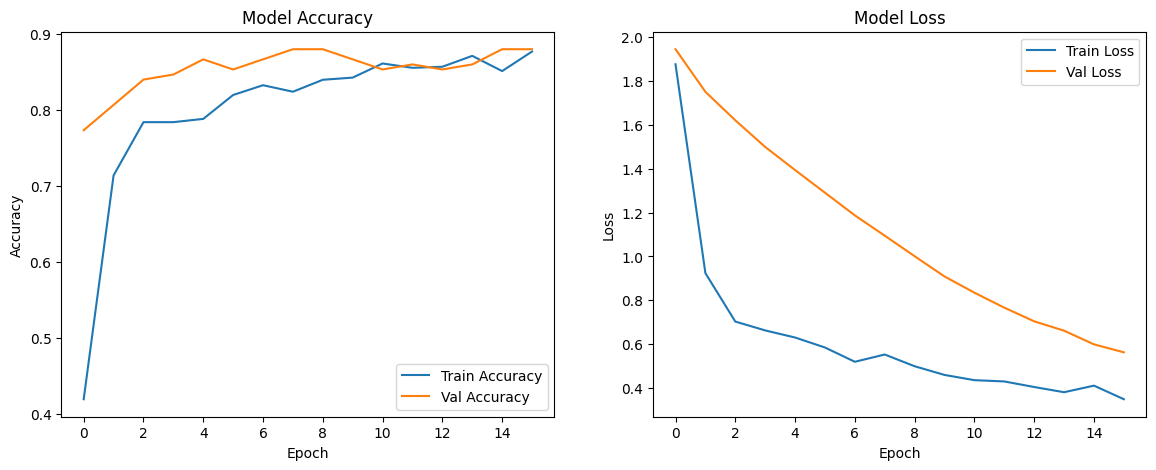

In [9]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
if USE_IMPROVED_MODEL:
    X_eval, y_eval = seq_test, y_test_seq
else:
    X_eval, y_eval = X_test, y_test

y_pred_probs = model.predict(X_eval)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_eval if len(y_eval.shape) == 1 else np.argmax(y_eval, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels_sorted))
print(f"\nTest Accuracy: {accuracy_score(y_true, y_pred):.4f}")


5/5 [==============================] - 0s 12ms/step

Classification Report:
              precision    recall  f1-score   support

       blues       0.78      0.93      0.85        15
   classical       0.94      1.00      0.97        15
     country       0.83      0.67      0.74        15
       disco       0.87      0.87      0.87        15
      hiphop       0.76      0.87      0.81        15
        jazz       1.00      0.87      0.93        15
       metal       1.00      0.93      0.97        15
         pop       0.91      0.67      0.77        15
      reggae       0.86      0.80      0.83        15
        rock       0.60      0.80      0.69        15

    accuracy                           0.84       150
   macro avg       0.85      0.84      0.84       150
weighted avg       0.85      0.84      0.84       150


Test Accuracy: 0.8400


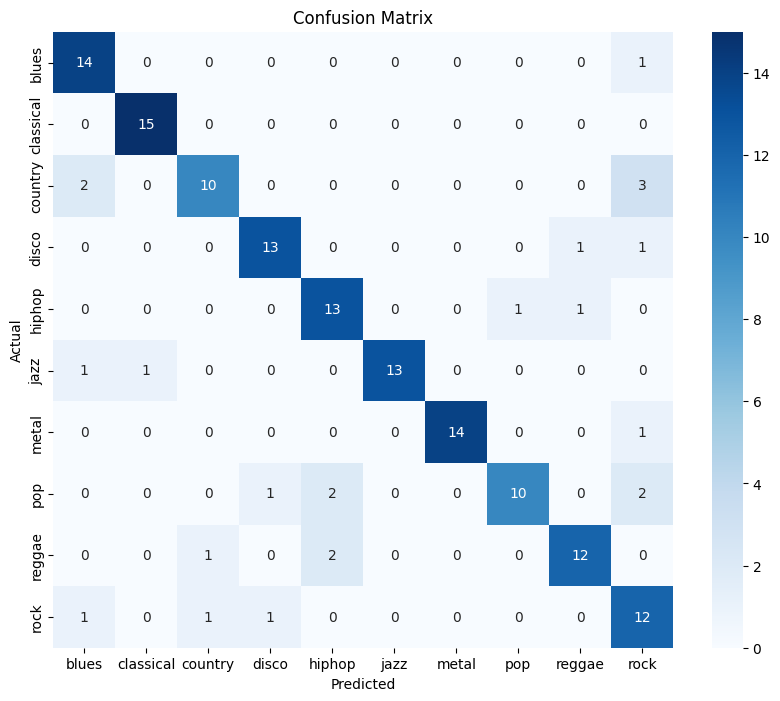

In [11]:
target_names = [
    'blues', 'classical', 'country', 'disco', 'hiphop',
    'jazz', 'metal', 'pop', 'reggae', 'rock'
]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()